In [10]:
import os
import numpy as np
import pandas as pd

from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

loading red_fox image folder...
*completed red_fox folder*
loading virginia_opossum image folder...
*completed virginia_opossum folder*
loading raccoon image folder...
*completed raccoon folder*
loading mountain_beaver image folder...
*completed mountain_beaver folder*
loading gray_wolf image folder...
*completed gray_wolf folder*
loading deer image folder...
*completed deer folder*
loading coyote image folder...
*completed coyote folder*


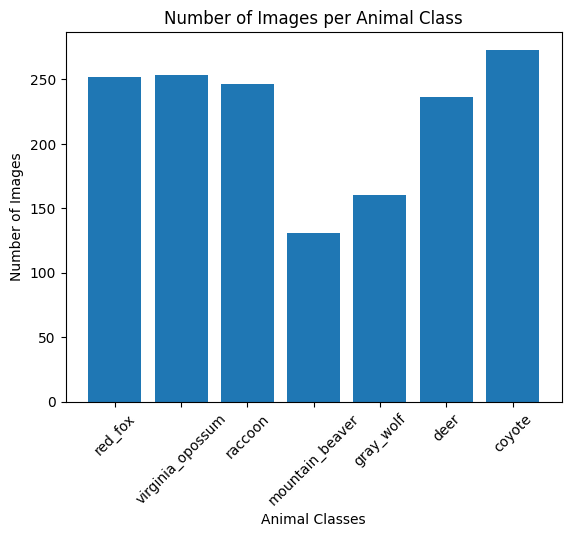


img_data shape (before processing): (1551, 224, 224, 3)
class_labels shape: (1551,)
Number of samples in the dataset: 1551


In [11]:
### Image Loading and Resizing, Data metrics
animals = ['red_fox','virginia_opossum','raccoon','mountain_beaver','gray_wolf','deer','coyote']
img_data_arr = []
class_label_arr = []

datadir = r"C:\Users\Using Janani\Downloads\oregon_wildlife\oregon_wildlife\oregon_wildlife"
feature_shape = () # variable to print out the feature array's size
num_img_per_animal = [] # array holding number of images per folder
for i in animals:
    print(f"loading {i} image folder...")
    path = os.path.join(datadir, i)
    num_img_per_animal.append(len(os.listdir(path))) # append number of images in each animal folder
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224), color_mode="rgb") # loads image, sizes it to 224x224, and forces it to be rgb (handles a couple of transparent images)
        img_array = tf.keras.preprocessing.image.img_to_array(img) # Turns the image into a numpy array
        img_data_arr.append(img_array) # appends single image array to total image array
        class_label_arr.append(animals.index(i)) # appends that image's class to total class array
    print(f"*completed {i} folder*")

img_data = np.array(img_data_arr)
class_labels = np.array(class_label_arr)

# Bar chart of Images per Animal Class
plt.bar(animals, num_img_per_animal)
plt.xlabel('Animal Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.title('Number of Images per Animal Class')
plt.show()

print("\nimg_data shape (before processing):", img_data.shape)
print("class_labels shape:", class_labels.shape)
print(f"Number of samples in the dataset: {img_data.shape[0]}")


In [12]:
### Preprocessing and Feature Analysis
X_train_feat = []
X_test_feat = []

# using MobileNetV2 for feature analysis by doing include_top = False so it only returns 1280 size feature array
cnn_feat_alys = MobileNetV2(weights="imagenet", input_shape = (224, 224, 3), include_top=False, pooling="avg")  

# split train and test data before feature analysis
X_train, X_test, y_train, y_test = train_test_split(img_data, class_labels, test_size=0.3, random_state=42)

for img_array in X_train:
    img_array = np.expand_dims(img_array, axis=0) # reshapes the pixels in the array to fit cnn model expectation
    img_array = preprocess_input(img_array) # matches input pixel values to how cnn model was trained
    features = cnn_feat_alys.predict(img_array, verbose=0).flatten() # returns feature array
    feature_shape = features.shape
    X_train_feat.append(features)

for img_array in X_test:
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = cnn_feat_alys.predict(img_array, verbose=0).flatten()
    X_test_feat.append(features)

X_train_feat = np.array(X_train_feat)
X_test_feat = np.array(X_test_feat)

print(f"The features array shape from cnn_feat_alys.predict: {feature_shape}")
print(f"X_train_feat array shape: {X_train_feat.shape}")
print(f"X_test_feat array shape: {X_test_feat.shape}")
print("\ny_train shape:", y_train.shape)
print("\ny_test shape:", y_test.shape)

The features array shape from cnn_feat_alys.predict: (1280,)
X_train_feat array shape: (1085, 1280)
X_test_feat array shape: (466, 1280)

y_train shape: (1085,)

y_test shape: (466,)


### (a) Data Exploration:
I manually went through the image folders and removed images that were too small, blurry, had major watermarks, included multiple animals, and overall deleted images that would reduce the quality of the machine learning model. I tried to make sure all the classes had the same number of pictures in each folder, as shown by the above bar chart. There are two folders with less than 200 images, but overall the folders include a similar number of pictures. I printed out the shape of img_data which shows the amount of images loaded and the size of the flattened image in pixels; 1551 images, 224x224 pixel size, 3 channels (rgb). I used geeksforgeeks image classification using svm article as reference for how to load in my image files [1].

### (b) Preprocessing of Dataset:
When loading the images into my program, I made sure to resize all images to be a standard 224x224 pixel size for the MobileNetV2 CNN to work properly as well as to standardize the images; in the CNN instantiation, there is a variable called input_shape which I have declared as (224,224), thus the CNN expects that shape. There were a few images that were rgba, meaning the image had a transparency feature, I made sure to convert those images to standard rgb using color_mode="rgb" within the preprocessing.image.load_img function. I then turn the image into an array, use np.expand_dims to add a 4th dimension to signify 1 image coming into the CNN, and then use MobileNet's preprocess_input function to reshape the pixels in the array to fit model's expectations which are that the pixels are scaled to be between -1 and 1 to show light intensity instead of being between 0 and 255. I printed out the feature array shape as a check that the array comes back as size 1280. 

### (c) Feature Extraction:
I first split the dataset to train and test sets. I made sure to double check that X_train and X_test had compatible shapes with Y_train and Y_test by printing out their sizes and made sure test and train sizes equal the total image set size (1085 + 466 = 1551). I made sure also to split test and train datasets before feature analysis just in case, although the CNN makes sure there is no leakage is I were to split afterward as it has its trained on its own image set. I chose MobileNetV2's CNN to do feature analysis as it is a pretrained model that applies dozens of learned filters in 3 layers that detect edges, color gradients, textures, and shapes of the animals. I referenced the geeksforgeeks MobileNetV2 article as well as the documentation for MobileNetV2 on how to do feature analysis with MobileNetV2's CNN [3] and [4]. The classifier head is removed to be able to use the CNN as just a feature extractor, and it returns a 1280x1 size feature vector for every image by doing pooling='avg' (reduces feature matrix to feature vector).

In [13]:
### Selecting optimal C value and optimal kernal function for SVM:

# Here I am using GridSearch to test out multiple C and kernal options
param_grid = {
    'C': [1, 3, 5, 7, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.005, 0.01],
}

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

grid = GridSearchCV(SVC(decision_function_shape='ovr'), param_grid, cv=3, scoring=scoring, refit='f1_macro', n_jobs=-1, verbose=2) #3 fold cross validation, print out f1 score (good for multiclass)
grid.fit(X_train_feat, y_train)

# Printing out best solutions (SVM)
print(f"Best SVM model: {grid.best_estimator_}")
print(f"Best SVM parameters: {grid.best_params_}")
print(f"Best SVM F1 score: {grid.best_score_}")

print("SVM Table Showing parameters and their variables sorted from best to worst")
results = pd.DataFrame(grid.cv_results_)
cols_to_show = [
    'params',
    'mean_test_accuracy',
    'mean_test_f1_macro',
    'mean_test_precision_macro',
    'mean_test_recall_macro'
]
results[cols_to_show].sort_values(
    by='mean_test_f1_macro',
    ascending=False
).head(10)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best SVM model: SVC(C=3, gamma=0.005)
Best SVM parameters: {'C': 3, 'gamma': 0.005, 'kernel': 'rbf'}
Best SVM F1 score: 0.9510507004461086
SVM Table Showing parameters and their variables sorted from best to worst


,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro
9,"{'C': 3, 'gamma': 0.005, 'kernel': 'rbf'}",0.954842,0.951051,0.954500,0.949788
15,"{'C': 5, 'gamma': 0.005, 'kernel': 'rbf'}",0.954842,0.951051,0.954500,0.949788
21,"{'C': 7, 'gamma': 0.005, 'kernel': 'rbf'}",0.954842,0.951051,0.954500,0.949788
27,"{'C': 10, 'gamma': 0.005, 'kernel': 'rbf'}",0.954842,0.951051,0.954500,0.949788
13,"{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}",0.953919,0.950741,0.951348,0.951709
7,"{'C': 3, 'gamma': 0.001, 'kernel': 'rbf'}",0.953921,0.950703,0.952353,0.950946
3,"{'C': 1, 'gamma': 0.005, 'kernel': 'rbf'}",0.952995,0.948792,0.953814,0.946635
1,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.952995,0.948772,0.955180,0.945757
8,"{'C': 3, 'gamma': 0.005, 'kernel': 'linear'}",0.951156,0.947719,0.947997,0.947931
6,"{'C': 3, 'gamma': 0.001, 'kernel': 'linear'}",0.951156,0.947719,0.947997,0.947931


In [14]:
### Testing another ML model, Random Forest:
param_grid = {
    'n_estimators': [100, 200, 250], # number of trees in forest
    'max_depth': [15, 25, 30], # the maximum depth of the tree
    'min_samples_split': [4, 7, 10], # minimum samples required to split a node: larger values means smoother decision boundaries
    'max_features': ['sqrt', 'log2'] # how many features each tree sees
}

scoring = { 
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

grid2 = GridSearchCV(RandomForestClassifier(random_state=42),param_grid,cv=3, scoring=scoring, refit='f1_macro',n_jobs=-1,verbose=2)

grid2.fit(X_train_feat, y_train)

# Printing out best solutions (RF)
print(f"Best RF model: {grid2.best_estimator_}")
print(f"Best RF parameters: {grid2.best_params_}")
print(f"Best RF F1 score: {grid2.best_score_}")

print("Random Forest Table Showing parameters and their variables sorted from best to worst")
results = pd.DataFrame(grid2.cv_results_)
cols_to_show = [
    'params',
    'mean_test_accuracy',
    'mean_test_f1_macro',
    'mean_test_precision_macro',
    'mean_test_recall_macro'
]
results[cols_to_show].sort_values(
    by='mean_test_f1_macro',
    ascending=False
).head(10)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best RF model: RandomForestClassifier(max_depth=15, min_samples_split=7, n_estimators=250,
                       random_state=42)
Best RF parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 250}
Best RF F1 score: 0.9390126827430801
Random Forest Table Showing parameters and their variables sorted from best to worst


,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro
5,"{'max_depth': 15, 'max_features': 'sqrt', 'min...",0.944703,0.939013,0.948245,0.934278
23,"{'max_depth': 25, 'max_features': 'sqrt', 'min...",0.944703,0.939013,0.948245,0.934278
41,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",0.944703,0.939013,0.948245,0.934278
44,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",0.944703,0.938748,0.947450,0.934988
26,"{'max_depth': 25, 'max_features': 'sqrt', 'min...",0.944703,0.938748,0.947450,0.934988
8,"{'max_depth': 15, 'max_features': 'sqrt', 'min...",0.944703,0.938748,0.947450,0.934988
7,"{'max_depth': 15, 'max_features': 'sqrt', 'min...",0.944705,0.938387,0.947563,0.934616
25,"{'max_depth': 25, 'max_features': 'sqrt', 'min...",0.944705,0.938387,0.947563,0.934616
43,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",0.944705,0.938387,0.947563,0.934616
37,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",0.943777,0.937175,0.946801,0.932843


### (d) Processing of each dataset using two different machine learning methods:
I chose SVM and Random Forest for the two machine learning methods. I chose SVM because it is very good at classification with optimal feature extraction (which is given by the CNN model); I referenced geeksforgeeks multiclass classfication using svm article for how to use SVM/SVC, specifically for multiclass classification [2]. I chose Random Forest for the other model because it is also good at classification as it uses collective decision making of multiple decision trees to make accurate predictions. This is good as it is combining the predictions of multiple individual decision trees, with the final class determined by a majority vote. For both methods, I wanted to find the optimal value that would produce the best F1 score (as F1 score is a good indicator for multiclass models). For this I used gridSearch which tests all the possible combinations in the parameter grid and uses cross validation to evaluate the preformance of the models. I chose k=3 for the number of folds due to memory constraints of my computer. For SVM i include multiple values for C, 2 different kernels (linear and rbf), and different gamma values pertaining to kernal rbf. I do this to evaluate how different margin strengths and kernel-induced decision boundaries affect the SVM’s ability to separate classes and generalize to unseen data. For Random Forest i include multiple values for n_estimators (number of trees in forest), max_depth, min_samples_split (minimum samples required to split a node), and max_features (how many features each tree sees). I do this to control model complexity, reduce overfitting, and determine the optimal forest configuration that maximizes cross-validated F1 performance. I also gather multiple evaluation metrics like accuracy, F1 score, precision, and recall, during cross-validation. The macro F1 score was used as the metric for best model to ensure balanced performance across all classes as F1 score is a good metric for multiclass evaluation.

I concluded that the best parameters are:
The Best SVM parameters: {'C': 3, 'gamma': 0.005, 'kernel': 'rbf'}
The Best RF parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 250}

In [15]:
### Final SVM Model, training with train data
best_svm = grid.best_estimator_ # best model, already trained from gridsearchcv
y_predict_svm = best_svm.predict(X_test_feat)
print("SVM F1 Using Testing Data:", f1_score(y_test, y_predict_svm, average="macro"))
print("SVM Test Data Accuracy:", accuracy_score(y_test, y_predict_svm))
print("Confusion Matrix for SVM Model:")
print(confusion_matrix(y_test, y_predict_svm))

SVM F1 Using Testing Data: 0.9563347359528327
SVM Test Data Accuracy: 0.9592274678111588
Confusion Matrix for SVM Model:
[[64  0  0  0  0  0  3]
 [ 0 85  0  0  0  0  0]
 [ 0  1 70  0  0  0  0]
 [ 0  0  0 33  0  0  0]
 [ 0  0  4  0 43  0  3]
 [ 0  0  0  0  0 79  0]
 [ 0  0  0  1  7  0 73]]


In [16]:
### Final SVM Model, training with train data
best_rf = grid2.best_estimator_
y_predict_rf = best_rf.predict(X_test_feat)
print("Random Forest F1 Using Testing Data:", f1_score(y_test, y_predict_rf, average="macro"))
print("Random Forest Test Data Accuracy:", accuracy_score(y_test, y_predict_rf))
print("Confusion Matrix for RF Model:")
print(confusion_matrix(y_test, y_predict_rf))

Random Forest F1 Using Testing Data: 0.9662021516131073
Random Forest Test Data Accuracy: 0.9656652360515021
Confusion Matrix for RF Model:
[[64  0  0  0  0  0  3]
 [ 0 85  0  0  0  0  0]
 [ 0  2 69  0  0  0  0]
 [ 0  0  0 33  0  0  0]
 [ 0  0  1  0 45  0  4]
 [ 0  0  0  0  0 79  0]
 [ 0  0  1  0  3  2 75]]


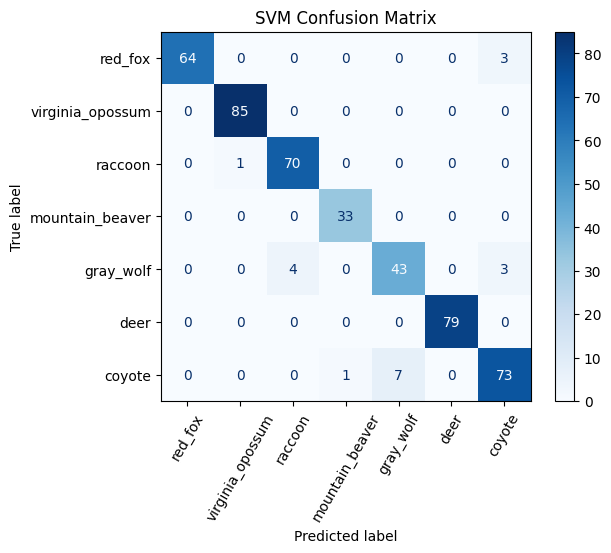

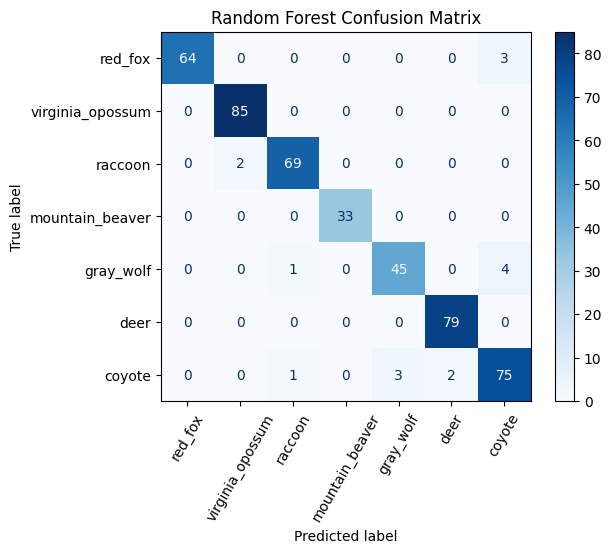

Classification Report for SVM: 
                  precision    recall  f1-score   support

         red_fox       1.00      0.96      0.98        67
virginia_opossum       0.99      1.00      0.99        85
         raccoon       0.95      0.99      0.97        71
 mountain_beaver       0.97      1.00      0.99        33
       gray_wolf       0.86      0.86      0.86        50
            deer       1.00      1.00      1.00        79
          coyote       0.92      0.90      0.91        81

        accuracy                           0.96       466
       macro avg       0.96      0.96      0.96       466
    weighted avg       0.96      0.96      0.96       466

Classification Report for Random Forest: 
                  precision    recall  f1-score   support

         red_fox       1.00      0.96      0.98        67
virginia_opossum       0.98      1.00      0.99        85
         raccoon       0.97      0.97      0.97        71
 mountain_beaver       1.00      1.00      1.00     

In [17]:
### Checking error rates with test data
confusion_svm = confusion_matrix(y_test, y_predict_svm)
confusion_rf = confusion_matrix(y_test, y_predict_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_svm, display_labels=animals)
disp.plot(cmap="Blues", xticks_rotation=60)
plt.title("SVM Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_rf, display_labels=animals)
disp.plot(cmap="Blues", xticks_rotation=60)
plt.title("Random Forest Confusion Matrix")
plt.show()

print("Classification Report for SVM: ")
print(classification_report(y_test, y_predict_svm, target_names=animals))
print("Classification Report for Random Forest: ")
print(classification_report(y_test, y_predict_rf, target_names=animals))


### (e) Comparative analysis of the two methods on each dataset:
I used the confusion matrix display documentation and the classification report documentation to model how to display the tables for RF and SVM [11] and [8]. Looking at the confusion matrices for both methods, SVM has a slightly hard time differentiating between grey wolf, coyote, and red fox. This is expected as the two animals are quite similar and because the original dataset was very mixed, there could have been a few wolfs that were within the coyote folder. RF also has a slight error with differentiating between grey wolf, coyote, and red fox, however this error was slightly smaller than SVM. Random Forest F1 Using Testing Data was 0.966 while SVM F1 Using Testing Data was 0.956, meaning that in terms of F1 score, Random Forest was better than SVM despite the training F1 rate for SVM was higher than RF. The SVM with an RBF kernel is more computationally complex than the Random Forest because it compares many data points to each other to find the best decision boundary, while the Random Forest trains many simpler decision trees independently, which is faster and scales better. 
Both SVM and Random Forest perform very good on the oregon_wildlife dataset, having high F1 scores that are 0.95 and 0.96. The SVM model has high precision and recall rates across most of the classes except gray_wolf and coyote. Random Forest has a slightly higher overall accuracy and F1 score while making fewer errors between these two classes. Random Forest is computationally simpler than SVM and works well with large dataset, whereas SVM with an RBF kernel takes more resourses even with the ovr model and it is slower to train. Thus, comparing the two sets, Random Forest is recommended for this dataset over SVM.

### (f) Discussion on ethical issues for this dataset/task:
Some ethical issues for this dataset are that I noticed there were several copyrighted images within the dataset, thus it seems that those images from kaggle may have not been collected with express consent. In addition, I noticed within the confusion matrix that there are some animals that were mixed up with each other, grey wolf, coyote, and red fox being one set, and I also noticed that grey wolf was sometimes classified as raccoons, which is a major error that could be deadly if a detection system were to say it was safe outside.

### (g) Bibliography:
[1] https://www.geeksforgeeks.org/machine-learning/image-classification-using-support-vector-machine-svm-in-python/ 

[2] https://www.geeksforgeeks.org/machine-learning/multi-class-classification-using-support-vector-machines-svm/ 

[3] https://www.geeksforgeeks.org/machine-learning/image-recognition-with-mobilenet/ 

[4] https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2

[5] https://www.geeksforgeeks.org/computer-vision/what-is-mobilenet-v2/ 

[6] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

[8] https://scikit-learn.org/0.15/modules/generated/sklearn.metrics.classification_report.html 

[9] https://keylabs.ai/blog/choosing-the-right-image-classification-algorithm/

[10] https://scikit-learn.org/stable/modules/svm.html#svm-kernels

[11] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html 

[12] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html